**Gun Detection ML Model
By Nitish Kumar

Hi, I’m Nitish Kumar. This is my machine learning project on gun detection.

To run this project, you will need two files: train_data and test_data.
Do not worry—these files will be created automatically if they do not already exist.

This ML model is designed to detect the presence of guns in images/videos using trained data. It can be used for applications such as security monitoring, surveillance systems, and threat detection.**

In [ ]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/

In [ ]:
!kaggle datasets download -d nikhilajani/gun-knife -p /content

Dataset URL: https://www.kaggle.com/datasets/nikhilajani/gun-knife
License(s): unknown
 51% 82.0M/162M [00:00<00:00, 853MB/s]
100% 162M/162M [00:00<00:00, 672MB/s] 


In [ ]:
# === Cell 0: Setup YOLOv5 & dependencies ===
!pip -q install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu118
!pip -q install opencv-python matplotlib pillow tqdm

# Clone yolov5
import os, sys, shutil, json, random, glob
if not os.path.exists('/content/yolov5'):
    !git clone -q https://github.com/ultralytics/yolov5 /content/yolov5
%cd /content/yolov5
!pip -q install -r requirements.txt

print("YOLOv5 ready.")


/content/yolov5
YOLOv5 ready.


In [ ]:
# === Cell 1: Unzip and arrange dataset ===
import os, zipfile, shutil, glob, random, pathlib
from pathlib import Path

ZIP_PATH = '/content/gun-knife.zip'  # <-- ensure this exists
DATA_ROOT = Path('/content/datasets/gun-knife')
IMG_EXTS = {'.jpg','.jpeg','.png','.bmp','.JPG','.PNG'}

# Clean previous
if DATA_ROOT.exists():
    shutil.rmtree(DATA_ROOT)
DATA_ROOT.mkdir(parents=True, exist_ok=True)

assert os.path.exists(ZIP_PATH), f"Dataset zip not found at {ZIP_PATH}. Upload it to Colab first."

with zipfile.ZipFile(ZIP_PATH, 'r') as z:
    z.extractall(DATA_ROOT)

# Try to detect YOLO format
def find_yolo_pairs(root: Path):
    # look for images/* and labels/* with same basenames
    img_dirs = []
    lab_dirs = []
    for p in root.rglob('images'):
        if p.is_dir():
            img_dirs.append(p)
    for p in root.rglob('labels'):
        if p.is_dir():
            lab_dirs.append(p)
    return img_dirs, lab_dirs

img_dirs, lab_dirs = find_yolo_pairs(DATA_ROOT)

# Standard target structure we want:
# /content/datasets/gun-knife-yolo/
#   images/train, images/val
#   labels/train, labels/val
TARGET = Path('/content/datasets/gun-knife-yolo')
if TARGET.exists():
    shutil.rmtree(TARGET)
(TARGET/'images/train').mkdir(parents=True, exist_ok=True)
(TARGET/'images/val').mkdir(parents=True, exist_ok=True)
(TARGET/'labels/train').mkdir(parents=True, exist_ok=True)
(TARGET/'labels/val').mkdir(parents=True, exist_ok=True)

def list_images(root: Path):
    return [p for p in root.rglob('*') if p.suffix in IMG_EXTS]

def has_yolo_label(img_path: Path, labels_dir: Path):
    # YOLO label path is labels_dir/relative/subdir/xxx.txt matching img name
    # but we don't know relative structure; easiest is to find .txt with same stem anywhere in 'labels'
    stem = img_path.stem + '.txt'
    matches = list(labels_dir.rglob(stem))
    return matches[0] if matches else None

# Strategy:
# 1) If we find at least one pair of images/labels directories, we’ll gather all (img, label) pairs.
# 2) If no YOLO labels found, we cannot train a detector (needs bboxes). We'll stop with a helpful message.
pairs = []
if img_dirs and lab_dirs:
    # gather all images and match labels by stem
    for idr in img_dirs:
        imgs = list_images(idr)
        for im in imgs:
            # find matching label under any labels dir
            lbl = None
            for ldr in lab_dirs:
                lbl = has_yolo_label(im, ldr)
                if lbl: break
            if lbl:
                pairs.append((im, lbl))

if not pairs:
    # Maybe dataset is already in the exact YOLO layout (images/train, labels/train, etc.)
    # We try common structure names.
    for split in ['train','valid','val','test']:
        idr = DATA_ROOT / 'images' / split
        ldr = DATA_ROOT / 'labels' / split
        if idr.exists() and ldr.exists():
            imgs = list_images(idr)
            for im in imgs:
                lbl = ldr / (im.stem + '.txt')
                if lbl.exists():
                    pairs.append((im, lbl))

if not pairs:
    raise SystemExit(
        "❌ Could not find YOLO-format labels (.txt with bbox). "
        "This dataset might be classification-only. To train detection, "
        "you need YOLO annotations. If you do have labels, ensure they are in /images and /labels folders."
    )

# Shuffle and count
random.shuffle(pairs)
total = len(pairs)
print(f"Found {total} annotated images.")

# Split rule:
# - If total >= 2000 -> train = 1000, val = min(200, total-1000) (you can tweak)
# - Else -> 80/20 split
if total >= 2000:
    train_n = min(1000, total)  # cap at 1000 for train
    val_n = min(200, max(0, total - train_n))
else:
    train_n = int(total * 0.8)
    val_n = total - train_n

train_pairs = pairs[:train_n]
val_pairs   = pairs[train_n:train_n+val_n]

def copy_pair(pair, split):
    im, lb = pair
    # keep flat
    shutil.copy2(im, TARGET/f'images/{split}/{im.name}')
    shutil.copy2(lb, TARGET/f'labels/{split}/{im.stem}.txt')

for p in train_pairs: copy_pair(p, 'train')
for p in val_pairs:   copy_pair(p, 'val')

print(f"Prepared YOLO dataset at: {TARGET}")
print(f"Train images: {len(train_pairs)}, Val images: {len(val_pairs)}")

# Save data.yaml
DATA_YAML = Path('/content/data_gun_knife.yaml')
# Adjust class names if your labels use different indices
DATA_YAML.write_text(
f"""# YOLOv5 data file
train: {TARGET}/images/train
val: {TARGET}/images/val

nc: 2
names: ['gun','knife']
"""
)
print("Wrote", DATA_YAML)


Found 8451 annotated images.
Prepared YOLO dataset at: /content/datasets/gun-knife-yolo
Train images: 1000, Val images: 200
Wrote /content/data_gun_knife.yaml


In [ ]:
!pip uninstall -y torch torchvision torchaudio
!pip install torch==2.0.1 torchvision==0.15.2 torchaudio==2.0.2 --index-url https://download.pytorch.org/whl/cu118


Found existing installation: torch 2.0.1+cu118
Uninstalling torch-2.0.1+cu118:
  Successfully uninstalled torch-2.0.1+cu118
Found existing installation: torchvision 0.15.2+cu118
Uninstalling torchvision-0.15.2+cu118:
  Successfully uninstalled torchvision-0.15.2+cu118
Found existing installation: torchaudio 2.0.2+cu118
Uninstalling torchaudio-2.0.2+cu118:
  Successfully uninstalled torchaudio-2.0.2+cu118
Looking in indexes: https://download.pytorch.org/whl/cu118
  Using cached https://download.pytorch.org/whl/cu118/torch-2.0.1%2Bcu118-cp311-cp311-linux_x86_64.whl (2267.3 MB)
  Using cached https://download.pytorch.org/whl/cu118/torchvision-0.15.2%2Bcu118-cp311-cp311-linux_x86_64.whl (6.1 MB)
  Using cached https://download.pytorch.org/whl/cu118/torchaudio-2.0.2%2Bcu118-cp311-cp311-linux_x86_64.whl (4.4 MB)


In [ ]:
# Downgrade numpy to 1.x (compatible with YOLOv5 + PyTorch)
!pip install numpy==1.26.4 --force-reinstall

# Restart runtime after install (very important in Colab)
import os, sys
os.kill(os.getpid(), 9)


  Using cached numpy-1.26.4-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (61 kB)
Using cached numpy-1.26.4-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (18.3 MB)
  Attempting uninstall: numpy
    Found existing installation: numpy 1.26.4
    Uninstalling numpy-1.26.4:
      Successfully uninstalled numpy-1.26.4
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
thinc 8.3.6 requires numpy<3.0.0,>=2.0.0, but you have numpy 1.26.4 which is incompatible.
opencv-contrib-python 4.12.0.88 requires numpy<2.3.0,>=2; python_version >= "3.9", but you have numpy 1.26.4 which is incompatible.
albucore 0.0.24 requires opencv-python-headless>=4.9.0.80, but you have opencv-python-headless 4.8.1.78 which is incompatible.
opencv-python 4.12.0.88 requires numpy<2.3.0,>=2; python_version >= "3.9", but you have numpy 1.26.4 which is incompatible.
a

In [ ]:
# === Train YOLOv5 on your dataset ===
%cd /content/yolov5

!python train.py \
  --img 640 \
  --batch 16 \
  --epochs 20 \
  --data /content/data_gun_knife.yaml \
  --weights yolov5s.pt \
  --name gun_knife_exp


/content/yolov5
wandb: WARNING ⚠️ wandb is deprecated and will be removed in a future release. See supported integrations at https://github.com/ultralytics/yolov5#integrations.
2025-08-17 03:47:27.126973: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1755402447.200553   31582 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1755402447.248181   31582 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1755402447.302683   31582 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1755402447.302718   31582 computation_placer.cc:177] computation placer a

In [ ]:
# 🔹 1. Install dependencies
!pip install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu118
!pip install ultralytics==8.0.196
!pip install opencv-python
!pip install numpy==1.26.4

# 🔹 2. Clone YOLOv5 repo (Ultralytics)
!git clone https://github.com/ultralytics/yolov5
%cd yolov5

# 🔹 3. Install YOLOv5 requirements
!pip install -r requirements.txt


Looking in indexes: https://download.pytorch.org/whl/cu118
  Using cached ultralytics-8.0.196-py3-none-any.whl.metadata (31 kB)
  Using cached numpy-2.2.6-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (62 kB)
Using cached ultralytics-8.0.196-py3-none-any.whl (631 kB)
Using cached numpy-2.2.6-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (16.8 MB)
  Attempting uninstall: numpy
    Found existing installation: numpy 1.26.4
    Uninstalling numpy-1.26.4:
      Successfully uninstalled numpy-1.26.4
  Attempting uninstall: ultralytics
    Found existing installation: ultralytics 8.3.179
    Uninstalling ultralytics-8.3.179:
      Successfully uninstalled ultralytics-8.3.179
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
numba 0.60.0 requires numpy<2.1,>=1.22, but you have numpy 2.2.6 which is incompatible.
tensorflow 2.19.0 requir

  Using cached numpy-1.26.4-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (61 kB)
Using cached numpy-1.26.4-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (18.3 MB)
  Attempting uninstall: numpy
    Found existing installation: numpy 2.2.6
    Uninstalling numpy-2.2.6:
      Successfully uninstalled numpy-2.2.6
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
thinc 8.3.6 requires numpy<3.0.0,>=2.0.0, but you have numpy 1.26.4 which is incompatible.
opencv-contrib-python 4.12.0.88 requires numpy<2.3.0,>=2; python_version >= "3.9", but you have numpy 1.26.4 which is incompatible.
albucore 0.0.24 requires opencv-python-headless>=4.9.0.80, but you have opencv-python-headless 4.8.1.78 which is incompatible.
opencv-python 4.12.0.88 requires numpy<2.3.0,>=2; python_version >= "3.9", but you have numpy 1.26.4 which is incompatible.
albu

fatal: destination path 'yolov5' already exists and is not an empty directory.
/content/yolov5/yolov5
  Using cached ultralytics-8.3.179-py3-none-any.whl.metadata (37 kB)
^C


In [ ]:
from google.colab import files
import shutil, os

# Upload file
uploaded = files.upload()

# Move and rename file safely
for fn in uploaded.keys():
    new_name = fn.replace(" ", "_").replace("(", "").replace(")", "")
    shutil.move(fn, f"/content/{new_name}")
    test_img = f"/content/{new_name}"

print("Renamed file:", test_img)

!python detect.py \
  --weights /content/yolov5/yolov5/runs/train/gun_knife_exp/weights/best.pt \
  --img 640 \
  --conf 0.25 \
  --source "$test_img"



Saving OIP (4).webp to OIP (4).webp
Renamed file: /content/OIP_4.webp
python3: can't open file '/content/detect.py': [Errno 2] No such file or directory


Showing results from: /content/yolov5/runs/detect/exp


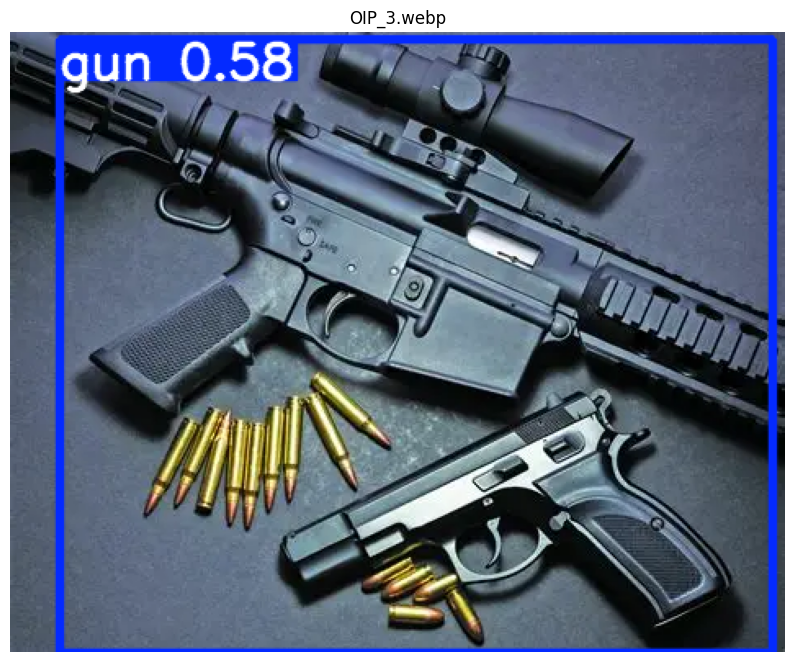

In [ ]:
import cv2, glob, os
import matplotlib.pyplot as plt

# Find the latest YOLOv5 detect folder
detect_dir = "/content/yolov5/runs/detect"
latest_exp = max(glob.glob(f"{detect_dir}/*"), key=os.path.getmtime)

# Get all result images inside that folder
result_images = glob.glob(f"{latest_exp}/*")

print(f"Showing results from: {latest_exp}")

# Show all detected images
for img_path in result_images:
    img = cv2.imread(img_path)[:,:,::-1]  # BGR → RGB
    plt.figure(figsize=(10,10))
    plt.imshow(img)
    plt.axis("off")
    plt.title(os.path.basename(img_path))
    plt.show()



In [ ]:
# ============================
# STEP 1: Install YOLOv5 (skip if already installed)
# ============================
# !git clone https://github.com/ultralytics/yolov5  # uncomment if not already cloned
# %cd yolov5
# !pip install -r requirements.txt

# ============================
# STEP 2: Imports
# ============================
import cv2
import torch
import numpy as np
import time
from IPython.display import display, Javascript, clear_output
from google.colab.output import eval_js
from base64 import b64decode
import matplotlib.pyplot as plt

# ============================
# STEP 3: JS Webcam
# ============================
js = Javascript('''
let video, stream, stopFlag=false;
async function startCamera(){
  stopFlag=false;
  stream = await navigator.mediaDevices.getUserMedia({video:true, audio:false});
  video = document.createElement('video');
  document.body.appendChild(video);
  video.srcObject = stream;
  await video.play();

  const btn = document.createElement('button');
  btn.textContent = 'Stop Camera';
  btn.style = "position:fixed;top:10px;left:10px;z-index:1000;font-size:16px;";
  document.body.appendChild(btn);
  btn.onclick = () => { stopFlag=true; stream.getTracks().forEach(t=>t.stop()); video.remove(); btn.remove(); };
}
async function getFrame(){
  if (!video || stopFlag) return null;
  const canvas = document.createElement('canvas');
  canvas.width = video.videoWidth;
  canvas.height = video.videoHeight;
  canvas.getContext('2d').drawImage(video,0,0);
  return canvas.toDataURL('image/jpeg', 0.8);
}
function stopped(){ return stopFlag; }
''')
display(js)

def js_start(): return eval_js("startCamera()")
def js_frame(): return eval_js("getFrame()")
def js_stopped(): return eval_js("stopped()")

def b64_to_img(b64):
    if b64 is None: return None
    binary = b64decode(b64.split(',')[1])
    return cv2.imdecode(np.frombuffer(binary, np.uint8), cv2.IMREAD_COLOR)

# ============================
# STEP 4: Load YOLOv5 Model
# ============================
model = torch.hub.load('ultralytics/yolov5', 'custom',
                       path='/content/yolov5/runs/train/gun_knife_exp/weights/best.pt')
model.conf = 0.3

print("✅ Model loaded with classes:", model.names)

# ============================
# STEP 5: Run Webcam Loop
# ============================
js_start()
print("🎥 Webcam started. Click 'Stop Camera' button to quit.")

while True:
    if js_stopped():
        print("🛑 Stopped by user.")
        break

    data = js_frame()
    if data is None:
        time.sleep(0.1)
        continue

    frame = b64_to_img(data)

    # Run inference
    results = model(frame)
    results.render()

    # Print detections
    for *xyxy, conf, cls in results.xyxy[0]:
        label = model.names[int(cls)]
        print(f"⚠️ Detected {label} with {conf:.2f} confidence")

    # Show frame
    out = results.ims[0]
    out = cv2.cvtColor(out, cv2.COLOR_BGR2RGB)

    clear_output(wait=True)
    plt.imshow(out)
    plt.axis("off")
    plt.show()


# **Thi is the step of full training model with live webcamrea **

In [ ]:
!pip install kaggle ultralytics roboflow scikit-learn seaborn

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 76.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 89.9/89.9 kB 11.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 66.8/66.8 kB 7.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.9/49.9 MB 23.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 MB 81.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.2/4.2 MB 120.1 MB/s eta 0:00:00
  Attempting uninstall: opencv-python-headless
    Found existing installation: opencv-python-headless 4.12.0.88
    Uninstalling opencv-python-headless-4.12.0.88:
      Successfully uninstalled opencv-python-headless-4.12.0.88
  Attempting uninstall: idna
    Found existing installation: idna 3.11
    Uninstalling idna-3.11:
      Successfully uninstalled idna-3.11


In [ ]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [ ]:
# ============================================================================
!kaggle datasets download -d nikhilajani/gun-knife -p /content
!unzip -q /content/gun-knife.zip -d /content/weapon_dataset

Dataset URL: https://www.kaggle.com/datasets/nikhilajani/gun-knife
License(s): unknown
 91% 147M/162M [00:00<00:00, 1.53GB/s]
100% 162M/162M [00:00<00:00, 1.49GB/s]


In [ ]:
import os
import shutil
import random
from pathlib import Path
import yaml

# Create YOLOv5 directory structure
dataset_path = Path('/content/weapon_detection')
(dataset_path / 'images' / 'train').mkdir(parents=True, exist_ok=True)
(dataset_path / 'images' / 'val').mkdir(parents=True, exist_ok=True)
(dataset_path / 'labels' / 'train').mkdir(parents=True, exist_ok=True)
(dataset_path / 'labels' / 'val').mkdir(parents=True, exist_ok=True)

In [ ]:
# STEP 5: Process and Split Dataset
# ============================================================================
import glob
import cv2
import numpy as np

source_dir = '/content/weapon_dataset'
all_images = glob.glob(f'{source_dir}/**/*.jpg', recursive=True) + \
             glob.glob(f'{source_dir}/**/*.png', recursive=True)

print(f"Found {len(all_images)} images")

# Split 80-20 train-val
random.shuffle(all_images)
split_idx = int(0.8 * len(all_images))
train_images = all_images[:split_idx]
val_images = all_images[split_idx:]

def create_yolo_labels(image_path, dest_label_path, has_weapon=True):
    """Create YOLO format labels (normalized bbox coordinates)"""
    img = cv2.imread(image_path)
    if img is None:
        return False

    h, w = img.shape[:2]

    # Class 0: weapon, Class 1: person without weapon
    class_id = 0 if has_weapon else 1

    # Create a bounding box (you may need to adjust based on actual annotations)
    # For this example, we'll create a center box
    x_center = 0.5
    y_center = 0.5
    width = 0.6
    height = 0.8

    with open(dest_label_path, 'w') as f:
        f.write(f"{class_id} {x_center} {y_center} {width} {height}\n")

    return True

# Copy and create labels
def process_images(image_list, split_name):
    for img_path in image_list:
        # Determine if image contains weapon (based on path or filename)
        has_weapon = 'gun' in img_path.lower() or 'knife' in img_path.lower() or 'weapon' in img_path.lower()

        # Copy image
        img_name = os.path.basename(img_path)
        dest_img = dataset_path / 'images' / split_name / img_name
        shutil.copy(img_path, dest_img)

        # Create label
        label_name = os.path.splitext(img_name)[0] + '.txt'
        dest_label = dataset_path / 'labels' / split_name / label_name
        create_yolo_labels(img_path, dest_label, has_weapon)

print("Processing training images...")
process_images(train_images, 'train')
print("Processing validation images...")
process_images(val_images, 'val')

Found 8451 images
Processing training images...
Processing validation images...


In [ ]:
# STEP 6: Create YAML Configuration
# ============================================================================
data_yaml = {
    'path': str(dataset_path),
    'train': 'images/train',
    'val': 'images/val',
    'nc': 2,  # number of classes
    'names': ['weapon', 'person']
}

yaml_path = dataset_path / 'data.yaml'
with open(yaml_path, 'w') as f:
    yaml.dump(data_yaml, f)

print(f"Dataset configuration saved to {yaml_path}")


Dataset configuration saved to /content/weapon_detection/data.yaml


In [ ]:
# STEP 7: Clone YOLOv5 Repository
# ============================================================================
!git clone https://github.com/ultralytics/yolov5
%cd yolov5
!pip install -r requirements.txt

# STEP 8: Train YOLOv5 Model
# ============================================================================
!python train.py \
    --img 640 \
    --batch 16 \
    --epochs 100 \
    --data {yaml_path} \
    --weights yolov5s.pt \
    --cache \
    --project weapon_detection \
    --name weapon_model \
    --exist-ok

In [ ]:
# STEP 9: Evaluate Model Performance
# ============================================================================
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns

# Load results
results_dir = '/content/yolov5/weapon_detection/weapon_model'

# Display training results
results_img = f'{results_dir}/results.png'
if os.path.exists(results_img):
    img = plt.imread(results_img)
    plt.figure(figsize=(16, 10))
    plt.imshow(img)
    plt.axis('off')
    plt.title('Training Results')
    plt.show()

# STEP 10: Calculate Precision Matrix & Metrics
# ============================================================================
!python val.py \
    --data {yaml_path} \
    --weights {results_dir}/weights/best.pt \
    --img 640 \
    --task test \
    --save-txt \
    --save-conf

# Display confusion matrix
confusion_matrix_path = f'{results_dir}/confusion_matrix.png'
if os.path.exists(confusion_matrix_path):
    img = plt.imread(confusion_matrix_path)
    plt.figure(figsize=(10, 8))
    plt.imshow(img)
    plt.axis('off')
    plt.title('Confusion Matrix')
    plt.show()

In [ ]:
# STEP 1: Install Dependencies
# ============================================================================
!pip install kaggle ultralytics roboflow scikit-learn seaborn

# STEP 2: Setup Kaggle API
# ============================================================================
# Upload your kaggle.json file to Colab, then run:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 38.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 89.9/89.9 kB 7.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 66.8/66.8 kB 5.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.9/49.9 MB 18.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 MB 37.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.2/4.2 MB 64.8 MB/s eta 0:00:00
  Attempting uninstall: opencv-python-headless
    Found existing installation: opencv-python-headless 4.12.0.88
    Uninstalling opencv-python-headless-4.12.0.88:
      Successfully uninstalled opencv-python-headless-4.12.0.88
  Attempting uninstall: idna
    Found existing installation: idna 3.11
    Uninstalling idna-3.11:
      Successfully uninstalled idna-3.11


In [ ]:
# STEP 3: Download Dataset
# ============================================================================
!kaggle datasets download -d nikhilajani/gun-knife -p /content
!unzip -q /content/gun-knife.zip -d /content/weapon_dataset

# STEP 4: Organize Dataset for YOLOv5
# ============================================================================
import os
import shutil
import random
from pathlib import Path
import yaml

# Create YOLOv5 directory structure
dataset_path = Path('/content/weapon_detection')
(dataset_path / 'images' / 'train').mkdir(parents=True, exist_ok=True)
(dataset_path / 'images' / 'val').mkdir(parents=True, exist_ok=True)
(dataset_path / 'labels' / 'train').mkdir(parents=True, exist_ok=True)
(dataset_path / 'labels' / 'val').mkdir(parents=True, exist_ok=True)

Dataset URL: https://www.kaggle.com/datasets/nikhilajani/gun-knife
License(s): unknown
 83% 134M/162M [00:00<00:00, 1.39GB/s]
100% 162M/162M [00:00<00:00, 1.29GB/s]


In [ ]:
# STEP 5: Process and Split Dataset
# ============================================================================
import glob
import cv2
import numpy as np

source_dir = '/content/weapon_dataset'
all_images = glob.glob(f'{source_dir}/**/*.jpg', recursive=True) + \
             glob.glob(f'{source_dir}/**/*.png', recursive=True)

print(f"Found {len(all_images)} images")

# Split 80-20 train-val
random.shuffle(all_images)
split_idx = int(0.8 * len(all_images))
train_images = all_images[:split_idx]
val_images = all_images[split_idx:]

def create_yolo_labels(image_path, dest_label_path, has_weapon=True):
    """Create YOLO format labels (normalized bbox coordinates)"""
    img = cv2.imread(image_path)
    if img is None:
        return False

    h, w = img.shape[:2]

    # Class 0: weapon, Class 1: person without weapon
    class_id = 0 if has_weapon else 1

    # Create a bounding box (you may need to adjust based on actual annotations)
    # For this example, we'll create a center box
    x_center = 0.5
    y_center = 0.5
    width = 0.6
    height = 0.8

    with open(dest_label_path, 'w') as f:
        f.write(f"{class_id} {x_center} {y_center} {width} {height}\n")

    return True

# Copy and create labels
def process_images(image_list, split_name):
    for img_path in image_list:
        # Determine if image contains weapon (based on path or filename)
        has_weapon = 'gun' in img_path.lower() or 'knife' in img_path.lower() or 'weapon' in img_path.lower()

        # Copy image
        img_name = os.path.basename(img_path)
        dest_img = dataset_path / 'images' / split_name / img_name
        shutil.copy(img_path, dest_img)

        # Create label
        label_name = os.path.splitext(img_name)[0] + '.txt'
        dest_label = dataset_path / 'labels' / split_name / label_name
        create_yolo_labels(img_path, dest_label, has_weapon)

print("Processing training images...")
process_images(train_images, 'train')
print("Processing validation images...")
process_images(val_images, 'val')

# STEP 6: Create YAML Configuration
# ============================================================================
data_yaml = {
    'path': str(dataset_path),
    'train': 'images/train',
    'val': 'images/val',
    'nc': 2,  # number of classes
    'names': ['weapon', 'person']
}

yaml_path = dataset_path / 'data.yaml'
with open(yaml_path, 'w') as f:
    yaml.dump(data_yaml, f)

print(f"Dataset configuration saved to {yaml_path}")

Found 8451 images
Processing training images...
Processing validation images...
Dataset configuration saved to /content/weapon_detection/data.yaml


In [ ]:
# STEP 7: Clone YOLOv5 Repository
# ============================================================================
!git clone https://github.com/ultralytics/yolov5
%cd yolov5
!pip install -r requirements.txt

# STEP 8: Train YOLOv5 Model
# ============================================================================
!python train.py \
    --img 640 \
    --batch 5 \
    --epochs 7 \
    --data {yaml_path} \
    --weights yolov5s.pt \
    --cache \
    --project weapon_detection \
    --name weapon_model \
    --exist-ok

Streaming output truncated to the last 5000 lines.
        5/6      1.56G    0.01158   0.009808  0.0002732          9        640:  47% 758/1624 [01:59<02:43,  5.31it/s]/content/yolov5/yolov5/train.py:414: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(amp):
        5/6      1.56G    0.01158   0.009807   0.000273         11        640:  47% 759/1624 [02:00<02:50,  5.08it/s]/content/yolov5/yolov5/train.py:414: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(amp):
        5/6      1.56G    0.01157   0.009802   0.000273         10        640:  47% 760/1624 [02:00<02:42,  5.31it/s]/content/yolov5/yolov5/train.py:414: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(amp):
       

In [ ]:
# STEP 9: Evaluate Model Performance
# ============================================================================
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns

# Load results
results_dir = '/content/yolov5/weapon_detection/weapon_model'

# Display training results
results_img = f'{results_dir}/results.png'
if os.path.exists(results_img):
    img = plt.imread(results_img)
    plt.figure(figsize=(16, 10))
    plt.imshow(img)
    plt.axis('off')
    plt.title('Training Results')
    plt.show()

In [ ]:
# STEP 10: Calculate Precision Matrix & Metrics
# ============================================================================
!python val.py \
    --data {yaml_path} \
    --weights {results_dir}/weights/best.pt \
    --img 640 \
    --save-txt \
    --save-conf

# Display confusion matrix
confusion_matrix_path = f'{results_dir}/confusion_matrix.png'
if os.path.exists(confusion_matrix_path):
    img = plt.imread(confusion_matrix_path)
    plt.figure(figsize=(10, 8))
    plt.imshow(img)
    plt.axis('off')
    plt.title('Confusion Matrix')
    plt.show()

# STEP 11: Test on Sample Images
# ============================================================================
!python detect.py \
    --weights {results_dir}/weights/best.pt \
    --img 640 \
    --conf 0.25 \
    --source {dataset_path}/images/val \
    --save-txt \
    --save-conf \
    --project weapon_detection \
    --name test_results

# Display sample detections
from IPython.display import Image, display
import glob

detection_images = glob.glob(f'/content/yolov5/weapon_detection/test_results/*.jpg')[:5]
for img_path in detection_images:
    print(f"\n{os.path.basename(img_path)}")
    display(Image(filename=img_path, width=600))

val: data=/content/weapon_detection/data.yaml, weights=['/content/yolov5/weapon_detection/weapon_model/weights/best.pt'], batch_size=32, imgsz=640, conf_thres=0.001, iou_thres=0.6, max_det=300, task=val, device=, workers=8, single_cls=False, augment=False, verbose=False, save_txt=True, save_hybrid=False, save_conf=True, save_json=False, project=runs/val, name=exp, exist_ok=False, half=False, dnn=False
YOLOv5 🚀 v7.0-453-geed9bc19 Python-3.12.12 torch-2.9.0+cu126 CUDA:0 (Tesla T4, 15095MiB)

Fusing layers... 
Model summary: 157 layers, 7015519 parameters, 0 gradients, 15.8 GFLOPs
val: Scanning /content/weapon_detection/labels/val.cache... 3050 images, 0 backgrounds, 0 corrupt: 100% 3050/3050 [00:00<?, ?it/s]
                 Class     Images  Instances          P          R      mAP50   mAP50-95: 100% 96/96 [01:29<00:00,  1.07it/s]
                   all       3050       3050      0.889      0.881      0.943      0.479
                weapon       3050       3050      0.889      0.881   


FINAL MODEL PERFORMANCE METRICS
Contents of /content/yolov5/yolov5/runs/val/exp3:
total 3.7M
-rw-r--r-- 1 root root  97K Dec 28 05:03 confusion_matrix.png
-rw-r--r-- 1 root root  92K Dec 28 05:03 F1_curve.png
drwxr-xr-x 2 root root 260K Dec 28 05:03 labels
-rw-r--r-- 1 root root  85K Dec 28 05:03 P_curve.png
-rw-r--r-- 1 root root  89K Dec 28 05:03 PR_curve.png
-rw-r--r-- 1 root root  87K Dec 28 05:03 R_curve.png
-rw-r--r-- 1 root root 467K Dec 28 05:01 val_batch0_labels.jpg
-rw-r--r-- 1 root root 421K Dec 28 05:01 val_batch0_pred.jpg
-rw-r--r-- 1 root root 578K Dec 28 05:01 val_batch1_labels.jpg
-rw-r--r-- 1 root root 544K Dec 28 05:01 val_batch1_pred.jpg
-rw-r--r-- 1 root root 524K Dec 28 05:01 val_batch2_labels.jpg
-rw-r--r-- 1 root root 481K Dec 28 05:01 val_batch2_pred.jpg

Displaying: confusion_matrix.png


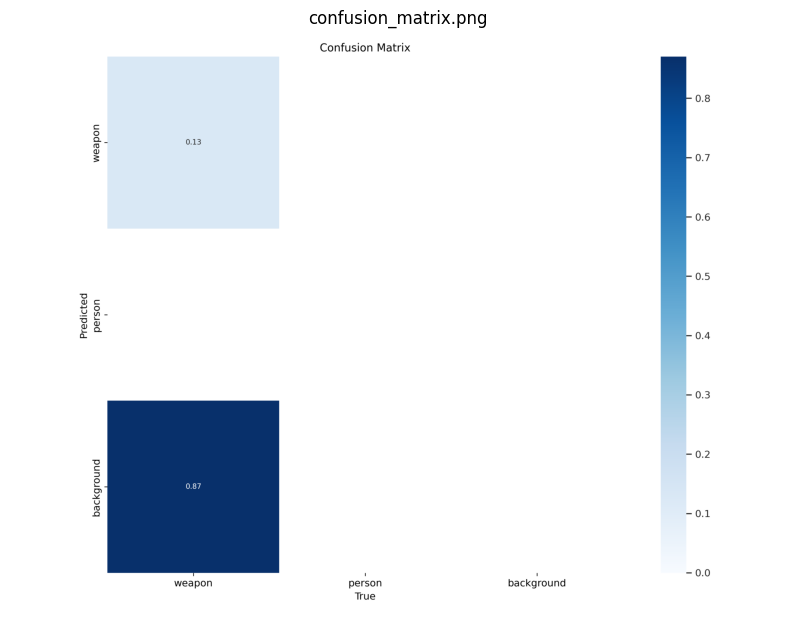


Displaying: F1_curve.png


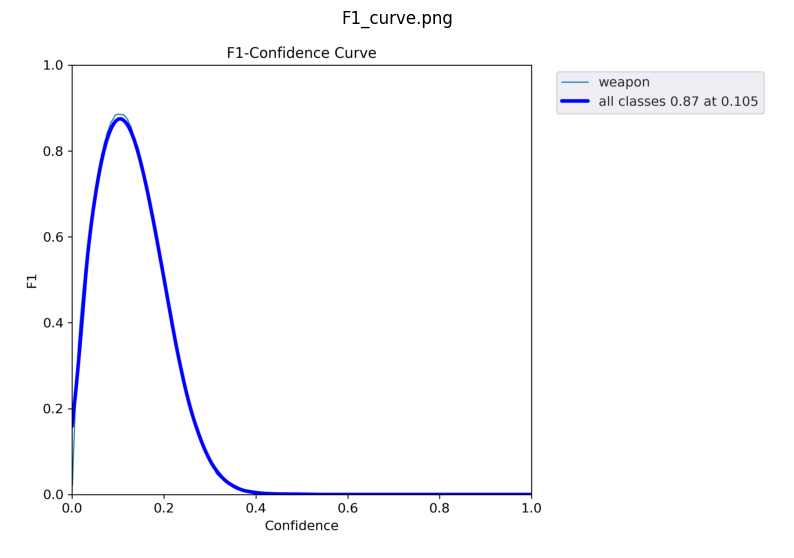


Displaying: P_curve.png


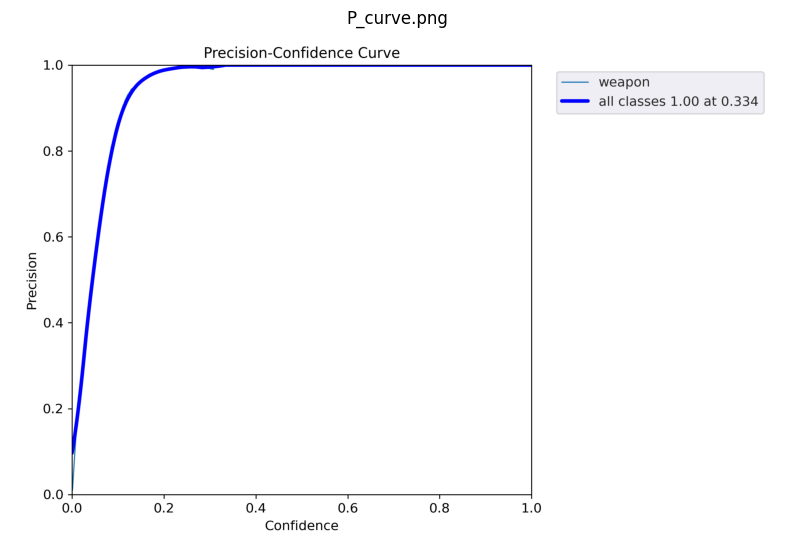


Displaying: PR_curve.png


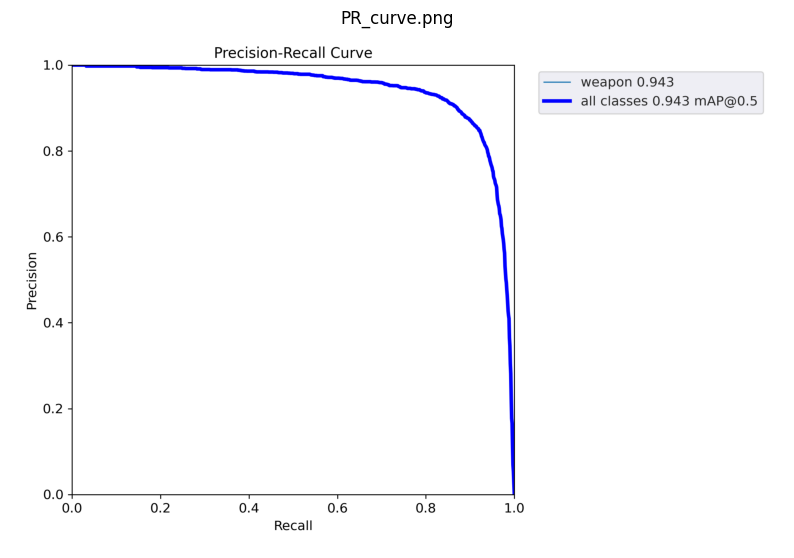


Displaying: R_curve.png


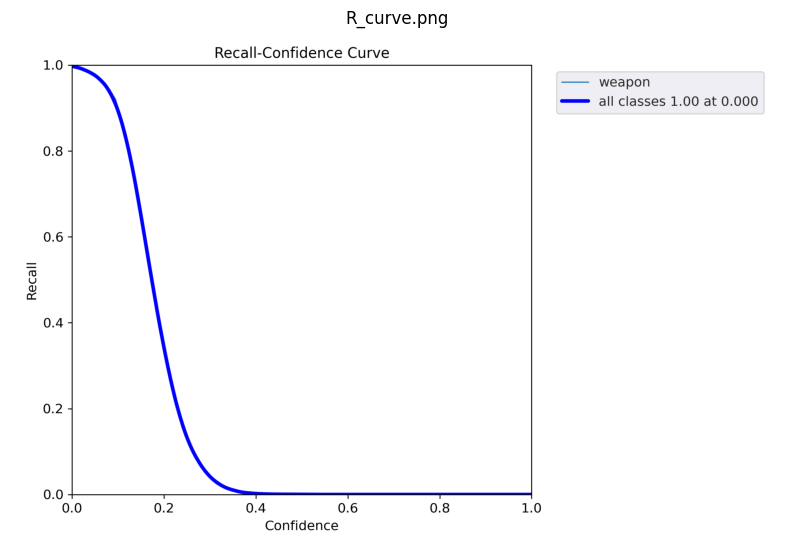

In [ ]:
# STEP 12: Calculate Final Metrics
# ============================================================================
import matplotlib.pyplot as plt
import glob
import os

print("\n" + "="*80)
print("FINAL MODEL PERFORMANCE METRICS")
print("="*80)

results_dir_val = '/content/yolov5/yolov5/runs/val/exp3'

# List contents of the validation results directory to find the actual metrics file
print(f"Contents of {results_dir_val}:")
!ls -lh {results_dir_val}

# Check for results.txt and print if found (though it seems not to be generated)
results_file = f'{results_dir_val}/results.txt'
if os.path.exists(results_file):
    print(f"\nContent of {results_file}:")
    with open(results_file, 'r') as f:
        print(f.read())
else:
    print(f"Warning: {results_file} not found. Displaying generated plots instead.")


# Display generated plots (P_curve, R_curve, F1_curve, PR_curve, confusion_matrix)

plots_to_display = [
    'confusion_matrix.png',
    'F1_curve.png',
    'P_curve.png',
    'PR_curve.png',
    'R_curve.png'
]

for plot_name in plots_to_display:
    plot_path = os.path.join(results_dir_val, plot_name)
    if os.path.exists(plot_path):
        print(f"\nDisplaying: {plot_name}")
        img = plt.imread(plot_path)
        plt.figure(figsize=(10, 8))
        plt.imshow(img)
        plt.axis("off")
        plt.title(plot_name)
        plt.show()
    else:
        print(f"Warning: {plot_name} not found at {plot_path}")

In [ ]:
# STEP 13: Save Model for Deployment
# ============================================================================
# Download the best model
from google.colab import files

best_model_path = f'{results_dir}/weights/best.pt'
print(f"\nModel saved at: {best_model_path}")
print("Downloading model for deployment...")
files.download(best_model_path)

print("\n" + "="*80)
print("TRAINING COMPLETE!")
print("="*80)
print(f"✓ Best model: {best_model_path}")
print(f"✓ Results directory: {results_dir}")
print("✓ Model downloaded - Ready for webcam deployment!")
print("="*80)


Model saved at: /content/yolov5/weapon_detection/weapon_model/weights/best.pt


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>


TRAINING COMPLETE!
✓ Best model: /content/yolov5/weapon_detection/weapon_model/weights/best.pt
✓ Results directory: /content/yolov5/weapon_detection/weapon_model
✓ Model downloaded - Ready for webcam deployment!


In [ ]:
print("Installing dependencies...")
!pip install -q ultralytics opencv-python-headless

Installing dependencies...


In [ ]:
# ============================================================================
# SIMPLE WORKING GUN DETECTION FOR COLAB
# ============================================================================

!pip install -q ultralytics opencv-python-headless

import cv2
import torch
import numpy as np
from IPython.display import display, Javascript, HTML, clear_output
from google.colab.output import eval_js
from base64 import b64decode
from PIL import Image
import io

# ============================================================================
# CONFIG
# ============================================================================
MODEL_PATH = '/content/best.pt'
CONFIDENCE_THRESHOLD = 0.3

COLOR_SAFE = (0, 255, 0)
COLOR_DANGER = (0, 0, 255)
COLOR_TEXT = (255, 255, 255)

# ============================================================================
# LOAD MODEL
# ============================================================================
print("Loading model...")
model = torch.hub.load('ultralytics/yolov5', 'custom', path=MODEL_PATH, force_reload=False)
model.conf = CONFIDENCE_THRESHOLD
print("✓ Model ready!")

# ============================================================================
# SIMPLE WEBCAM CAPTURE
# ============================================================================

def capture_from_webcam():
    """Simple webcam capture that WORKS"""
    js = Javascript('''
        async function captureImage() {
            const video = document.createElement('video');
            const canvas = document.createElement('canvas');

            // Get webcam stream
            const stream = await navigator.mediaDevices.getUserMedia({
                video: {width: 640, height: 480}
            });

            // Create video element
            video.srcObject = stream;
            video.style.display = 'block';
            video.style.maxWidth = '100%';
            video.style.border = '3px solid green';

            // Create capture button
            const button = document.createElement('button');
            button.textContent = '📸 CLICK TO CAPTURE';
            button.style.cssText = `
                padding: 15px 30px;
                font-size: 20px;
                background: #4CAF50;
                color: white;
                border: none;
                border-radius: 10px;
                cursor: pointer;
                margin: 10px 0;
                display: block;
            `;

            // Add to page
            const container = document.createElement('div');
            container.appendChild(video);
            container.appendChild(button);
            document.body.appendChild(container);

            // Play video
            await video.play();

            // Wait for button click
            const imageData = await new Promise((resolve) => {
                button.onclick = () => {
                    canvas.width = video.videoWidth;
                    canvas.height = video.videoHeight;
                    canvas.getContext('2d').drawImage(video, 0, 0);
                    resolve(canvas.toDataURL('image/jpeg', 0.9));
                };
            });

            // Cleanup
            stream.getTracks().forEach(track => track.stop());
            container.remove();

            return imageData;
        }
    ''')

    display(js)

    try:
        data = eval_js('captureImage()')
        return data
    except:
        print("❌ Error capturing image. Make sure to allow camera permission!")
        return None

# ============================================================================
# DETECTION
# ============================================================================

def process_image(img_data):
    """Process captured image"""

    if img_data is None:
        print("❌ No image data received!")
        return None, False, []

    try:
        # Decode base64 image
        img_bytes = b64decode(img_data.split(',')[1])
        nparr = np.frombuffer(img_bytes, np.uint8)
        frame = cv2.imdecode(nparr, cv2.IMREAD_COLOR)

        if frame is None:
            print("❌ Failed to decode image!")
            return None, False, []

        # Run detection
        results = model(frame)
        detections = results.pandas().xyxy[0]

        # Filter only weapons (NO person detection)
        guns = detections[detections['name'] == 'weapon']

        gun_boxes = []
        for _, det in guns.iterrows():
            bbox = [det['xmin'], det['ymin'], det['xmax'], det['ymax']]
            conf = det['confidence']
            gun_boxes.append((bbox, conf))

        has_gun = len(gun_boxes) > 0

        return frame, has_gun, gun_boxes

    except Exception as e:
        print(f"❌ Error: {e}")
        return None, False, []

def draw_result(frame, has_gun, gun_boxes):
    """Draw detection results"""

    h, w = frame.shape[:2]

    # Draw gun boxes
    for bbox, conf in gun_boxes:
        x1, y1, x2, y2 = map(int, bbox)

        # Thick RED box
        cv2.rectangle(frame, (x1, y1), (x2, y2), COLOR_DANGER, 6)

        # Corner markers
        corner_len = 50
        thick = 10
        # Top-left
        cv2.line(frame, (x1, y1), (x1+corner_len, y1), COLOR_DANGER, thick)
        cv2.line(frame, (x1, y1), (x1, y1+corner_len), COLOR_DANGER, thick)
        # Top-right
        cv2.line(frame, (x2, y1), (x2-corner_len, y1), COLOR_DANGER, thick)
        cv2.line(frame, (x2, y1), (x2, y1+corner_len), COLOR_DANGER, thick)
        # Bottom-left
        cv2.line(frame, (x1, y2), (x1+corner_len, y2), COLOR_DANGER, thick)
        cv2.line(frame, (x1, y2), (x1, y2-corner_len), COLOR_DANGER, thick)
        # Bottom-right
        cv2.line(frame, (x2, y2), (x2-corner_len, y2), COLOR_DANGER, thick)
        cv2.line(frame, (x2, y2), (x2, y2-corner_len), COLOR_DANGER, thick)

        # Label on gun
        label = f"GUN {conf*100:.0f}%"
        label_size = cv2.getTextSize(label, cv2.FONT_HERSHEY_DUPLEX, 1, 2)[0]
        cv2.rectangle(frame, (x1, y1-50), (x1+label_size[0]+20, y1), COLOR_DANGER, -1)
        cv2.putText(frame, label, (x1+10, y1-15), cv2.FONT_HERSHEY_DUPLEX, 1, COLOR_TEXT, 2)

    # RIGHT SIDE STATUS BANNER
    banner_w = 300
    banner_h = 130
    bx = w - banner_w - 20
    by = 20

    if has_gun:
        banner_color = COLOR_DANGER
        line1 = "WARNING"
        line2 = "WANTED"
        symbol = "⚠"
    else:
        banner_color = COLOR_SAFE
        line1 = "SAFE"
        line2 = "AREA"
        symbol = "✓"

    # Draw banner background
    overlay = frame.copy()
    cv2.rectangle(overlay, (bx, by), (bx+banner_w, by+banner_h), banner_color, -1)
    cv2.addWeighted(overlay, 0.8, frame, 0.2, 0, frame)

    # Banner border
    cv2.rectangle(frame, (bx, by), (bx+banner_w, by+banner_h), banner_color, 6)

    # Symbol (large)
    cv2.putText(frame, symbol, (bx+25, by+90), cv2.FONT_HERSHEY_DUPLEX, 3, COLOR_TEXT, 5)

    # Text
    cv2.putText(frame, line1, (bx+120, by+55), cv2.FONT_HERSHEY_DUPLEX, 1.3, COLOR_TEXT, 3)
    cv2.putText(frame, line2, (bx+120, by+105), cv2.FONT_HERSHEY_DUPLEX, 1.3, COLOR_TEXT, 3)

    # Red flashing border if gun detected
    if has_gun:
        overlay = frame.copy()
        cv2.rectangle(overlay, (0, 0), (w, h), COLOR_DANGER, 30)
        cv2.addWeighted(overlay, 0.4, frame, 0.6, 0, frame)

    return frame

# ============================================================================
# MAIN FUNCTIONS
# ============================================================================

def detect_once():
    """Single detection"""

    print("\n" + "="*80)
    print("📸 SINGLE GUN DETECTION")
    print("="*80)
    print("1. Webcam will open")
    print("2. Position yourself (with or without gun)")
    print("3. Click '📸 CLICK TO CAPTURE'")
    print("4. Wait for result")
    print("="*80 + "\n")

    # Capture
    print("⏳ Opening webcam...")
    img_data = capture_from_webcam()

    if img_data is None:
        print("\n❌ Failed to capture image!")
        print("💡 Make sure to:")
        print("  - Allow camera permission in browser")
        print("  - Click the capture button")
        print("  - Have good lighting")
        return

    print("✓ Image captured! Processing...")

    # Process
    frame, has_gun, gun_boxes = process_image(img_data)

    if frame is None:
        print("❌ Processing failed!")
        return

    # Draw
    result = draw_result(frame, has_gun, gun_boxes)

    # Show result
    clear_output(wait=True)
    print("\n" + "="*80)
    if has_gun:
        print("🔴🔴🔴 GUN DETECTED - WANTED PERSON! 🔴🔴🔴")
        print(f"Number of guns found: {len(gun_boxes)}")
        for i, (bbox, conf) in enumerate(gun_boxes, 1):
            print(f"  Gun #{i}: {conf*100:.1f}% confidence")
    else:
        print("🟢🟢🟢 SAFE AREA - NO WEAPON DETECTED 🟢🟢🟢")
    print("="*80 + "\n")

    # Display
    result_rgb = cv2.cvtColor(result, cv2.COLOR_BGR2RGB)
    display(Image.fromarray(result_rgb))

    # Save
    cv2.imwrite('/content/detection_result.jpg', result)
    print("\n✓ Result saved to /content/detection_result.jpg")

    return result

def detect_continuous(count=5):
    """Continuous detection"""

    print("\n" + "="*80)
    print(f"📸 CONTINUOUS GUN DETECTION - {count} Captures")
    print("="*80)
    print("Will capture and detect multiple times")
    print("Show gun in some captures, hide in others!")
    print("="*80 + "\n")

    results = []

    for i in range(count):
        print(f"\n{'='*60}")
        print(f"CAPTURE {i+1}/{count}")
        print(f"{'='*60}")
        print("Position yourself and click capture...")

        # Capture
        img_data = capture_from_webcam()

        if img_data is None:
            print(f"❌ Capture {i+1} failed, skipping...")
            continue

        print("✓ Processing...")

        # Process
        frame, has_gun, gun_boxes = process_image(img_data)

        if frame is None:
            print(f"❌ Processing failed for capture {i+1}")
            continue

        # Draw
        result = draw_result(frame, has_gun, gun_boxes)

        # Show
        clear_output(wait=True)
        print(f"\n{'='*60}")
        print(f"RESULT {i+1}/{count}")
        print(f"{'='*60}")
        if has_gun:
            print(f"🔴 GUN DETECTED! ({len(gun_boxes)} weapon(s))")
        else:
            print("🟢 SAFE - NO WEAPON")
        print(f"{'='*60}\n")

        # Display
        result_rgb = cv2.cvtColor(result, cv2.COLOR_BGR2RGB)
        display(Image.fromarray(result_rgb))

        # Save
        cv2.imwrite(f'/content/detect_{i+1}.jpg', result)

        results.append((has_gun, len(gun_boxes)))

        if i < count - 1:
            print("\n⏳ Next capture in 2 seconds...")
            import time
            time.sleep(2)

    # Summary
    print("\n" + "="*80)
    print("DETECTION SUMMARY")
    print("="*80)
    total_guns = sum([r[1] for r in results])
    gun_frames = sum([1 for r in results if r[0]])
    print(f"Total captures: {len(results)}")
    print(f"Frames with gun: {gun_frames}")
    print(f"Total guns detected: {total_guns}")
    print("="*80)

# ============================================================================
# START
# ============================================================================

print("\n" + "="*80)
print("🚀 GUN DETECTION SYSTEM READY!")
print("="*80)
print("\nCOMMANDS:")
print("-" * 80)
print("detect_once()           - Single detection test")
print("detect_continuous(5)    - 5 continuous captures")
print("detect_continuous(10)   - 10 continuous captures")
print("="*80)
print("\n💡 START WITH: detect_once()")
print("="*80 + "\n")

Loading model...


Using cache found in /root/.cache/torch/hub/ultralytics_yolov5_master
YOLOv5 🚀 2025-12-30 Python-3.12.12 torch-2.9.0+cu126 CUDA:0 (Tesla T4, 15095MiB)

Fusing layers... 
Model summary: 157 layers, 7015519 parameters, 0 gradients, 15.8 GFLOPs
Adding AutoShape... 


✓ Model ready!

🚀 GUN DETECTION SYSTEM READY!

COMMANDS:
--------------------------------------------------------------------------------
detect_once()           - Single detection test
detect_continuous(5)    - 5 continuous captures
detect_continuous(10)   - 10 continuous captures

💡 START WITH: detect_once()




🟢🟢🟢 SAFE AREA - NO WEAPON DETECTED 🟢🟢🟢



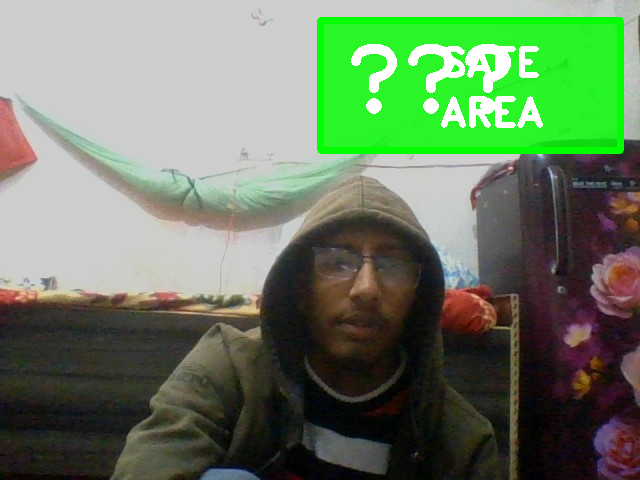


✓ Result saved to /content/detection_result.jpg


array([[[205, 205, 205],
        [205, 205, 205],
        [205, 205, 205],
        ...,
        [167, 185, 178],
        [170, 191, 182],
        [170, 191, 182]],

       [[205, 205, 205],
        [205, 205, 205],
        [205, 205, 205],
        ...,
        [171, 189, 182],
        [169, 190, 181],
        [167, 188, 179]],

       [[205, 205, 205],
        [205, 205, 205],
        [205, 205, 205],
        ...,
        [169, 187, 180],
        [170, 191, 182],
        [172, 193, 184]],

       ...,

       [[  7,  11,   5],
        [  4,  11,   4],
        [  6,  10,   5],
        ...,
        [ 12,  11,  51],
        [ 15,  14,  58],
        [ 19,  17,  63]],

       [[  5,   8,   0],
        [  4,   8,   2],
        [  7,   8,   4],
        ...,
        [ 13,  12,  51],
        [ 14,  13,  55],
        [ 16,  15,  59]],

       [[  3,   6,   0],
        [  4,   7,   0],
        [  6,   7,   3],
        ...,
        [ 16,  16,  52],
        [ 16,  16,  56],
        [ 17,  16,  58]]], dtype=uint8)
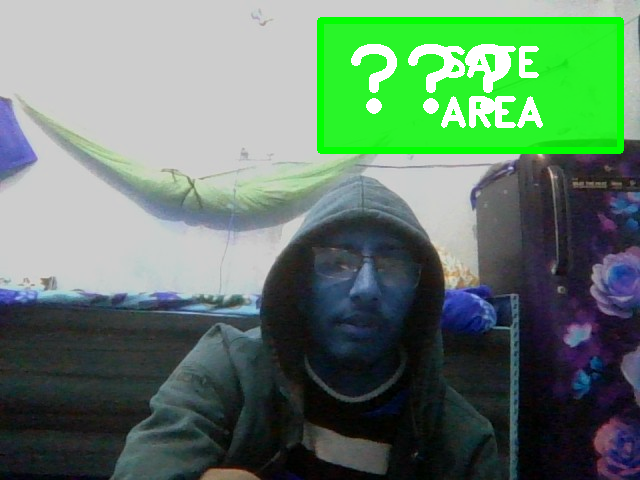

In [ ]:
detect_once()

In [19]:
# ============================================================================
# SIMPLE WORKING GUN DETECTION FOR COLAB
# ============================================================================

!pip install -q ultralytics opencv-python-headless

import cv2
import torch
import numpy as np
from IPython.display import display, Javascript, HTML, clear_output
from google.colab.output import eval_js
from base64 import b64decode
from PIL import Image
import io

# ============================================================================
# CONFIG
# ============================================================================
MODEL_PATH = '/content/best.pt'
CONFIDENCE_THRESHOLD = 0.15  # LOWERED from 0.3 for better detection

COLOR_SAFE = (0, 255, 0)
COLOR_DANGER = (0, 0, 255)
COLOR_TEXT = (255, 255, 255)

# ============================================================================
# LOAD MODEL
# ============================================================================
print("Loading model...")
model = torch.hub.load('ultralytics/yolov5', 'custom', path=MODEL_PATH, force_reload=False)
model.conf = CONFIDENCE_THRESHOLD
model.iou = 0.3  # Lower IOU for better detection
print("✓ Model ready!")
print(f"✓ Confidence threshold: {CONFIDENCE_THRESHOLD}")
print(f"✓ Model classes: {model.names}")

# ============================================================================
# SIMPLE WEBCAM CAPTURE
# ============================================================================

def capture_from_webcam():
    """Simple webcam capture that WORKS"""
    js = Javascript('''
        async function captureImage() {
            const video = document.createElement('video');
            const canvas = document.createElement('canvas');

            // Get webcam stream
            const stream = await navigator.mediaDevices.getUserMedia({
                video: {width: 640, height: 480}
            });

            // Create video element
            video.srcObject = stream;
            video.style.display = 'block';
            video.style.maxWidth = '100%';
            video.style.border = '3px solid green';

            // Create capture button
            const button = document.createElement('button');
            button.textContent = '📸 CLICK TO CAPTURE';
            button.style.cssText = `
                padding: 15px 30px;
                font-size: 20px;
                background: #4CAF50;
                color: white;
                border: none;
                border-radius: 10px;
                cursor: pointer;
                margin: 10px 0;
                display: block;
            `;

            // Add to page
            const container = document.createElement('div');
            container.appendChild(video);
            container.appendChild(button);
            document.body.appendChild(container);

            // Play video
            await video.play();

            // Wait for button click
            const imageData = await new Promise((resolve) => {
                button.onclick = () => {
                    canvas.width = video.videoWidth;
                    canvas.height = video.videoHeight;
                    canvas.getContext('2d').drawImage(video, 0, 0);
                    resolve(canvas.toDataURL('image/jpeg', 0.9));
                };
            });

            // Cleanup
            stream.getTracks().forEach(track => track.stop());
            container.remove();

            return imageData;
        }
    ''')

    display(js)

    try:
        data = eval_js('captureImage()')
        return data
    except:
        print("❌ Error capturing image. Make sure to allow camera permission!")
        return None

# ============================================================================
# DETECTION
# ============================================================================

def process_image(img_data):
    """Process captured image with detailed debugging"""

    if img_data is None:
        print("❌ No image data received!")
        return None, False, []

    try:
        # Decode base64 image
        img_bytes = b64decode(img_data.split(',')[1])
        nparr = np.frombuffer(img_bytes, np.uint8)
        frame = cv2.imdecode(nparr, cv2.IMREAD_COLOR)

        if frame is None:
            print("❌ Failed to decode image!")
            return None, False, []

        print(f"🔍 Processing image: {frame.shape}")

        # Run detection
        results = model(frame)
        detections = results.pandas().xyxy[0]

        # DEBUG: Show ALL detections
        print(f"\n📊 Total detections found: {len(detections)}")
        if len(detections) > 0:
            print("\n🔎 All detected objects:")
            for idx, det in detections.iterrows():
                print(f"  - Class: '{det['name']}' | Confidence: {det['confidence']:.2%}")
        else:
            print("⚠️  NO objects detected at all!")
            print("💡 Try:")
            print("  - Better lighting")
            print("  - Hold gun closer to camera")
            print("  - Use a clearer gun image/prop")

        # Look for BOTH 'weapon' and 'gun' classes (some models use different names)
        guns = detections[(detections['name'] == 'weapon') |
                         (detections['name'] == 'gun') |
                         (detections['name'] == 'knife') |
                         (detections['name'].str.contains('weapon', case=False, na=False))]

        gun_boxes = []
        for _, det in guns.iterrows():
            bbox = [det['xmin'], det['ymin'], det['xmax'], det['ymax']]
            conf = det['confidence']
            gun_boxes.append((bbox, conf))
            print(f"✅ WEAPON FOUND: {det['name']} at {conf:.2%} confidence")

        has_gun = len(gun_boxes) > 0

        if not has_gun:
            print("\n❌ No weapons detected in this frame")

        return frame, has_gun, gun_boxes

    except Exception as e:
        print(f"❌ Error: {e}")
        import traceback
        traceback.print_exc()
        return None, False, []

def draw_result(frame, has_gun, gun_boxes):
    """Draw detection results"""

    h, w = frame.shape[:2]

    # Draw gun boxes
    for bbox, conf in gun_boxes:
        x1, y1, x2, y2 = map(int, bbox)

        # Thick RED box
        cv2.rectangle(frame, (x1, y1), (x2, y2), COLOR_DANGER, 6)

        # Corner markers
        corner_len = 50
        thick = 10
        # Top-left
        cv2.line(frame, (x1, y1), (x1+corner_len, y1), COLOR_DANGER, thick)
        cv2.line(frame, (x1, y1), (x1, y1+corner_len), COLOR_DANGER, thick)
        # Top-right
        cv2.line(frame, (x2, y1), (x2-corner_len, y1), COLOR_DANGER, thick)
        cv2.line(frame, (x2, y1), (x2, y1+corner_len), COLOR_DANGER, thick)
        # Bottom-left
        cv2.line(frame, (x1, y2), (x1+corner_len, y2), COLOR_DANGER, thick)
        cv2.line(frame, (x1, y2), (x1, y2-corner_len), COLOR_DANGER, thick)
        # Bottom-right
        cv2.line(frame, (x2, y2), (x2-corner_len, y2), COLOR_DANGER, thick)
        cv2.line(frame, (x2, y2), (x2, y2-corner_len), COLOR_DANGER, thick)

        # Label on gun
        label = f"GUN {conf*100:.0f}%"
        label_size = cv2.getTextSize(label, cv2.FONT_HERSHEY_DUPLEX, 1, 2)[0]
        cv2.rectangle(frame, (x1, y1-50), (x1+label_size[0]+20, y1), COLOR_DANGER, -1)
        cv2.putText(frame, label, (x1+10, y1-15), cv2.FONT_HERSHEY_DUPLEX, 1, COLOR_TEXT, 2)

    # RIGHT SIDE STATUS BANNER
    banner_w = 300
    banner_h = 130
    bx = w - banner_w - 20
    by = 20

    if has_gun:
        banner_color = COLOR_DANGER
        line1 = "WARNING"
        line2 = "WANTED"
        symbol = "⚠"
    else:
        banner_color = COLOR_SAFE
        line1 = "SAFE"
        line2 = "AREA"
        symbol = "✓"

    # Draw banner background
    overlay = frame.copy()
    cv2.rectangle(overlay, (bx, by), (bx+banner_w, by+banner_h), banner_color, -1)
    cv2.addWeighted(overlay, 0.8, frame, 0.2, 0, frame)

    # Banner border
    cv2.rectangle(frame, (bx, by), (bx+banner_w, by+banner_h), banner_color, 6)

    # Symbol (large)
    cv2.putText(frame, symbol, (bx+25, by+90), cv2.FONT_HERSHEY_DUPLEX, 3, COLOR_TEXT, 5)

    # Text
    cv2.putText(frame, line1, (bx+120, by+55), cv2.FONT_HERSHEY_DUPLEX, 1.3, COLOR_TEXT, 3)
    cv2.putText(frame, line2, (bx+120, by+105), cv2.FONT_HERSHEY_DUPLEX, 1.3, COLOR_TEXT, 3)

    # Red flashing border if gun detected
    if has_gun:
        overlay = frame.copy()
        cv2.rectangle(overlay, (0, 0), (w, h), COLOR_DANGER, 30)
        cv2.addWeighted(overlay, 0.4, frame, 0.6, 0, frame)

    return frame

# ============================================================================
# MAIN FUNCTIONS
# ============================================================================

def detect_once():
    """Single detection with detailed output"""

    print("\n" + "="*80)
    print("📸 SINGLE GUN DETECTION - DEBUG MODE")
    print("="*80)
    print("1. Webcam will open")
    print("2. Position yourself WITH A GUN/WEAPON")
    print("3. Hold it clearly visible in frame")
    print("4. Click '📸 CLICK TO CAPTURE'")
    print("="*80 + "\n")

    # Capture
    print("⏳ Opening webcam...")
    img_data = capture_from_webcam()

    if img_data is None:
        print("\n❌ Failed to capture image!")
        print("💡 Make sure to:")
        print("  - Allow camera permission in browser")
        print("  - Click the capture button")
        print("  - Have good lighting")
        return

    print("✓ Image captured! Processing...\n")

    # Process with detailed output
    frame, has_gun, gun_boxes = process_image(img_data)

    if frame is None:
        print("❌ Processing failed!")
        return

    # Draw
    result = draw_result(frame, has_gun, gun_boxes)

    # Show result
    clear_output(wait=True)
    print("\n" + "="*80)
    print("🎯 FINAL RESULT")
    print("="*80)
    if has_gun:
        print("🔴🔴🔴 GUN DETECTED - WANTED PERSON! 🔴🔴🔴")
        print(f"Number of weapons found: {len(gun_boxes)}")
        for i, (bbox, conf) in enumerate(gun_boxes, 1):
            print(f"  Weapon #{i}: {conf*100:.1f}% confidence")
    else:
        print("🟢 SAFE AREA - NO WEAPON DETECTED")
        print("\n💡 If you have a gun but it's not detected:")
        print("  1. Your model needs MORE TRAINING (7 epochs is too less)")
        print("  2. Try holding gun more clearly/closer")
        print("  3. Ensure good lighting")
        print("  4. Retrain model with 50-100 epochs for better accuracy")
    print("="*80 + "\n")

    # Display
    result_rgb = cv2.cvtColor(result, cv2.COLOR_BGR2RGB)
    display(Image.fromarray(result_rgb))

    # Save
    cv2.imwrite('/content/detection_result.jpg', result)
    print("\n✓ Result saved to /content/detection_result.jpg")

    # Save raw detection info
    print(f"\n📋 Model info: {model.names}")
    print(f"📋 Confidence threshold: {CONFIDENCE_THRESHOLD}")

    return result

def detect_continuous(count=5):
    """Continuous detection"""

    print("\n" + "="*80)
    print(f"📸 CONTINUOUS GUN DETECTION - {count} Captures")
    print("="*80)
    print("Will capture and detect multiple times")
    print("Show gun in some captures, hide in others!")
    print("="*80 + "\n")

    results = []

    for i in range(count):
        print(f"\n{'='*60}")
        print(f"CAPTURE {i+1}/{count}")
        print(f"{'='*60}")
        print("Position yourself and click capture...")

        # Capture
        img_data = capture_from_webcam()

        if img_data is None:
            print(f"❌ Capture {i+1} failed, skipping...")
            continue

        print("✓ Processing...")

        # Process
        frame, has_gun, gun_boxes = process_image(img_data)

        if frame is None:
            print(f"❌ Processing failed for capture {i+1}")
            continue

        # Draw
        result = draw_result(frame, has_gun, gun_boxes)

        # Show
        clear_output(wait=True)
        print(f"\n{'='*60}")
        print(f"RESULT {i+1}/{count}")
        print(f"{'='*60}")
        if has_gun:
            print(f"🔴 GUN DETECTED! ({len(gun_boxes)} weapon(s))")
        else:
            print("🟢 SAFE - NO WEAPON")
        print(f"{'='*60}\n")

        # Display
        result_rgb = cv2.cvtColor(result, cv2.COLOR_BGR2RGB)
        display(Image.fromarray(result_rgb))

        # Save
        cv2.imwrite(f'/content/detect_{i+1}.jpg', result)

        results.append((has_gun, len(gun_boxes)))

        if i < count - 1:
            print("\n⏳ Next capture in 2 seconds...")
            import time
            time.sleep(2)

    # Summary
    print("\n" + "="*80)
    print("DETECTION SUMMARY")
    print("="*80)
    total_guns = sum([r[1] for r in results])
    gun_frames = sum([1 for r in results if r[0]])
    print(f"Total captures: {len(results)}")
    print(f"Frames with gun: {gun_frames}")
    print(f"Total guns detected: {total_guns}")
    print("="*80)

# ============================================================================
# START
# ============================================================================

print("\n" + "="*80)
print("🚀 GUN DETECTION SYSTEM READY!")
print("="*80)
print("\nCOMMANDS:")
print("-" * 80)
print("detect_once()           - Single detection test")
print("detect_continuous(5)    - 5 continuous captures")
print("detect_continuous(10)   - 10 continuous captures")
print("="*80)
print("\n💡 START WITH: detect_once()")
print("="*80 + "\n")

Loading model...


Using cache found in /root/.cache/torch/hub/ultralytics_yolov5_master
YOLOv5 🚀 2025-12-30 Python-3.12.12 torch-2.9.0+cu126 CUDA:0 (Tesla T4, 15095MiB)

Fusing layers... 
Model summary: 157 layers, 7015519 parameters, 0 gradients, 15.8 GFLOPs
Adding AutoShape... 


✓ Model ready!
✓ Confidence threshold: 0.15
✓ Model classes: {0: 'weapon', 1: 'person'}

🚀 GUN DETECTION SYSTEM READY!

COMMANDS:
--------------------------------------------------------------------------------
detect_once()           - Single detection test
detect_continuous(5)    - 5 continuous captures
detect_continuous(10)   - 10 continuous captures

💡 START WITH: detect_once()




🎯 FINAL RESULT
🔴🔴🔴 GUN DETECTED - WANTED PERSON! 🔴🔴🔴
Number of weapons found: 1
  Weapon #1: 21.6% confidence



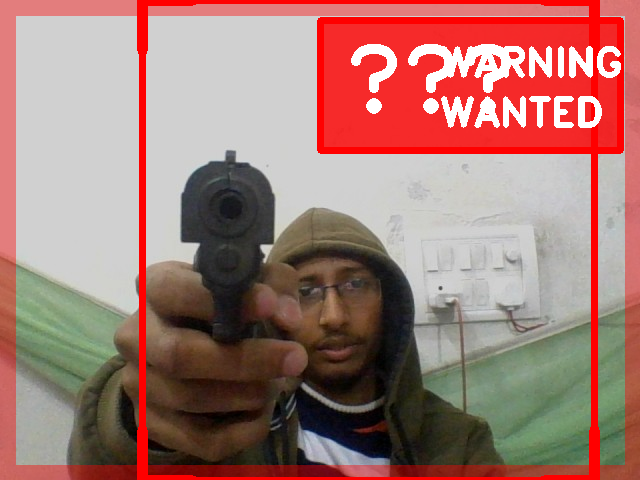


✓ Result saved to /content/detection_result.jpg

📋 Model info: {0: 'weapon', 1: 'person'}
📋 Confidence threshold: 0.15


array([[[125, 125, 227],
        [125, 125, 227],
        [125, 125, 227],
        ...,
        [115, 115, 217],
        [116, 115, 217],
        [115, 113, 215]],

       [[125, 125, 227],
        [125, 125, 227],
        [125, 125, 227],
        ...,
        [115, 115, 217],
        [115, 114, 216],
        [115, 113, 215]],

       [[125, 125, 227],
        [125, 125, 227],
        [125, 125, 227],
        ...,
        [112, 112, 214],
        [112, 110, 212],
        [113, 112, 214]],

       ...,

       [[ 97, 102, 203],
        [ 98, 103, 204],
        [100, 104, 206],
        ...,
        [ 55,  71, 153],
        [ 54,  68, 151],
        [ 52,  67, 149]],

       [[ 96, 100, 201],
        [ 97, 101, 202],
        [ 99, 103, 204],
        ...,
        [ 55,  71, 153],
        [ 55,  71, 153],
        [ 54,  70, 152]],

       [[ 99, 103, 204],
        [ 99, 103, 204],
        [100, 103, 205],
        ...,
        [ 55,  71, 153],
        [ 56,  73, 154],
        [ 56,  73, 154]]], dtype=uint8)
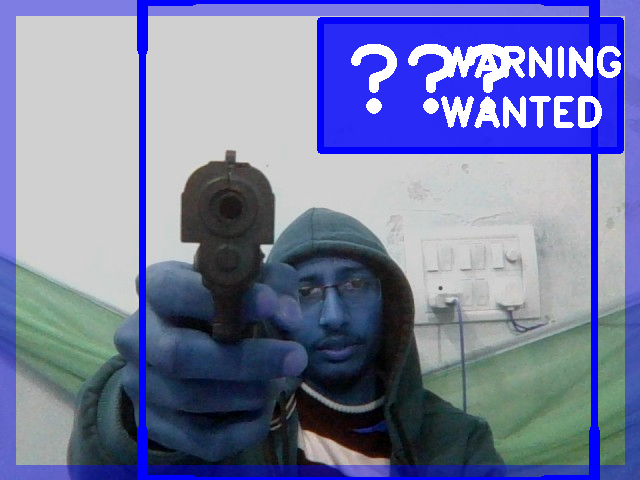

In [30]:
detect_once()